In [1]:
import matplotlib.pyplot as plt
import pymongo
import pandas as pd

from natsort import natsorted
from constants import *

In [2]:
client = pymongo.MongoClient('localhost', 27017)
db = client.mineral_db

In [3]:
minerals_in_pgm = {}

for x in db.mineral_coll.find():
    mineral = x['mineral_name']
    
    try:
        pgms = x['pgm']
    except:
        continue
        
    for pgm in pgms:
        if pgm in minerals_in_pgm.keys():
            minerals_in_pgm[pgm].append(mineral)
        else:
            minerals_in_pgm[pgm] = [ mineral ]

In [4]:
symmetry_indices = {
    'amorphous': 1,
    'triclinic': 2,
    'monoclinic': 4,
    'orthorhombic': 8,
    'trigonal': 12,
    'tetragonal': 16,
    'hexagonal': 24,
    'cubic': 48
}

pgm_symmetry_indices = {}
pgm_populations = {}
n_minerals_in_pgm = {}

for p in minerals_in_pgm.keys():
    pgm_pop = { cs: 0 for cs in symmetry_indices.keys() }
    num_minerals = 0
    pgm_sym_ind = 0
    
    for x in db.mineral_coll.find({ 'mineral_name': { '$in': minerals_in_pgm[p] } }):
        for crystal_system in x['crystal_systems']:
            if crystal_system in symmetry_indices.keys():
                pgm_pop[crystal_system] += 1
                num_minerals += 1
                pgm_sym_ind += symmetry_indices[crystal_system]
            
    try:
        pgm_symmetry_indices[p] = pgm_sym_ind / symmetry_indices['cubic'] / num_minerals
    except:
        pass
    
    pgm_populations[p] = pgm_pop
    n_minerals_in_pgm[p] = num_minerals
    
pgm_symmetry_indices = { p: pgm_symmetry_indices[p] for p in natsorted(pgm_symmetry_indices) }

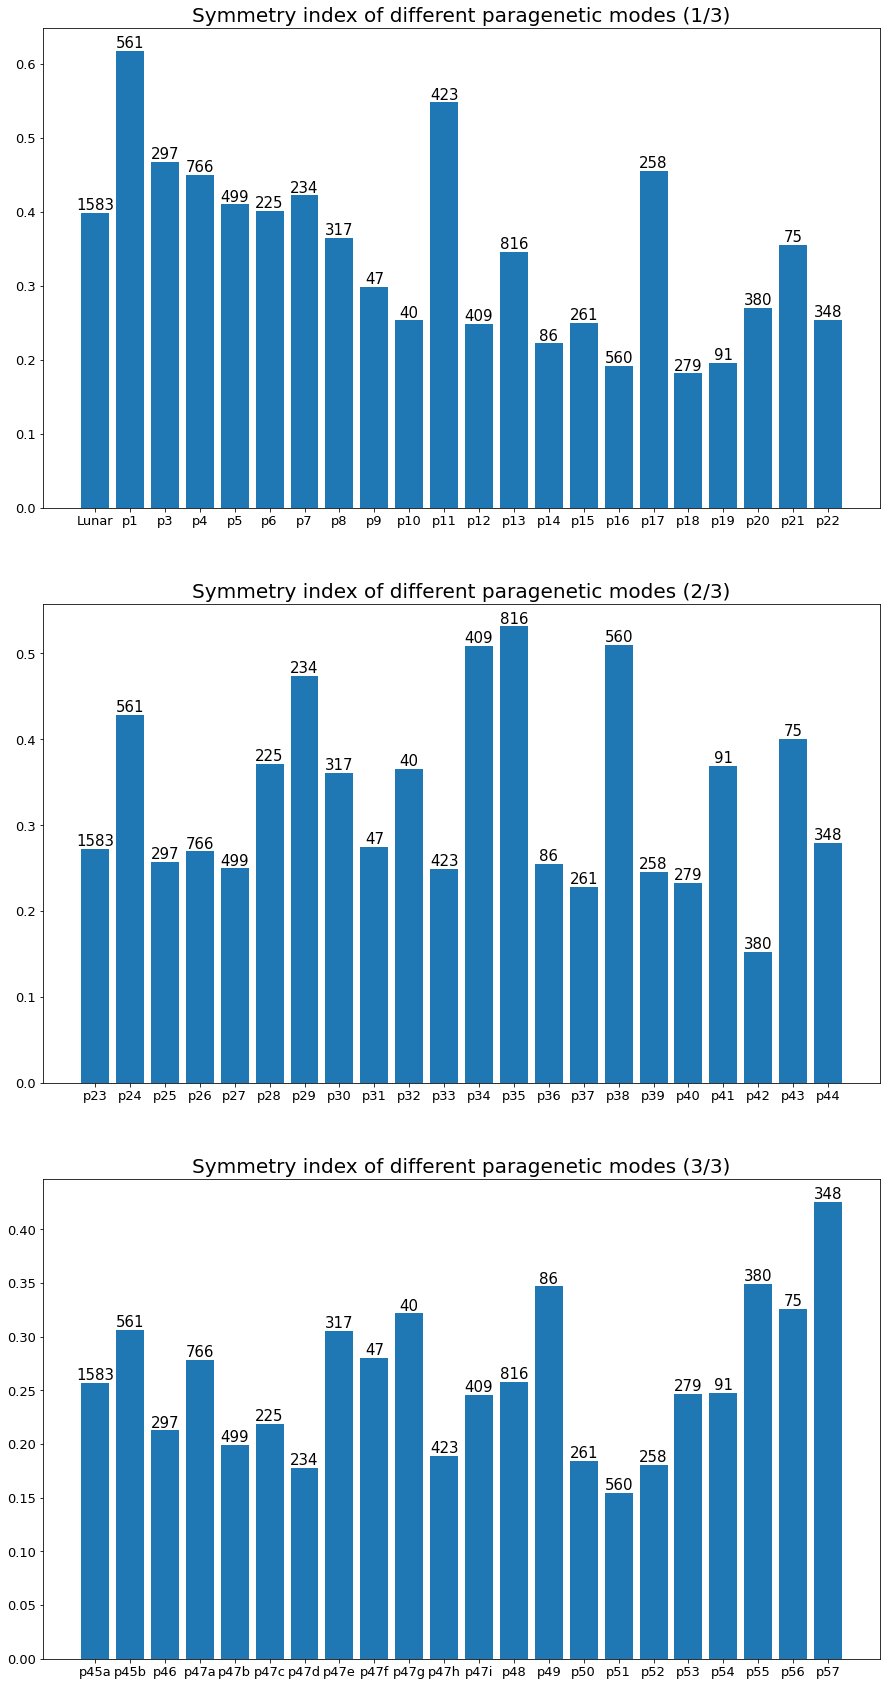

In [6]:
pgm_names = list(pgm_symmetry_indices.keys())

n_plots = 3
fig, ax = plt.subplots(n_plots, figsize=(15, 30))
l = len(pgm_symmetry_indices.keys())//n_plots

for i in range(n_plots):
    s, e = i*l, (i+1)*l
    
    bars = ax[i].bar(range(l), { pgm_symmetry_indices[p] for p in pgm_names[s:e] })
    ax[i].set_xticks(range(l), labels=pgm_names[s:e])
    ax[i].tick_params(axis='both', labelsize=FS_TICK)
    ax[i].set_title(f'Symmetry index of different paragenetic modes ({i+1}/{n_plots})', fontsize=FS_TITLE)

# [ print(f'{p}:\t {sym:.3f}') for p, sym in pgm_symmetry_indices.items() ]

    for n_minerals, bar in zip(n_minerals_in_pgm.values(), bars):
        ax[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                   f'{n_minerals}',
                   ha='center', va='bottom', fontsize=FS_SAMPLE
                  )

plt.savefig('results/graph_pgm.png')